In [1]:
             # Predicción precio de la soja octubre SEGUNDA PARTE
    
# Con nuestro dataset actualizado con nuestras predicciones hasta el 08/10,
# Lo que haremos será repetir el mismo proceso para poder determinar los
# próximos dias hóbiles solicitados en la competencia.




import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
df = pd.read_csv('ultimodatasetsoja2.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','cierre'])
df.head()

,cierre
fecha,
2004-05-01,221.0
2004-06-01,221.0
2004-07-01,219.0
2004-08-01,220.0
2004-09-01,220.0


In [3]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,cierre,weekday,month
fecha,,,
2004-05-01,221.0,5,5
2004-06-01,221.0,1,6
2004-07-01,219.0,3,7
2004-08-01,220.0,6,8
2004-09-01,220.0,2,9


In [4]:
df.describe()

,cierre,weekday,month
count,3882.000000,3882.000000,3882.000000
mean,259.882535,2.396703,6.476301
std,60.381344,1.719815,3.417611
min,146.000000,0.000000,1.000000
25%,221.000000,1.000000,4.000000
50%,257.000000,2.000000,6.000000
75%,300.375000,4.000000,9.000000
max,442.000000,6.000000,12.000000


In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
PASOS=7

# load dataset
values = df['cierre'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

df['scaled'] = scaled
scaledMerge=df.drop('cierre',axis=1)
#print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
reframed.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-14,5.0,5.0,-0.493243,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,...,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2,1,-0.445946
2004-01-15,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,...,-0.466216,1.0,1.0,-0.445946,2.0,1.0,-0.445946,3,1,-0.452703
2004-01-16,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,...,-0.445946,2.0,1.0,-0.445946,3.0,1.0,-0.452703,4,1,-0.459459
2004-01-19,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,...,-0.445946,3.0,1.0,-0.452703,4.0,1.0,-0.459459,0,1,-0.432432
2004-01-20,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,...,-0.452703,4.0,1.0,-0.459459,0.0,1.0,-0.432432,1,1,-0.412162


In [7]:
newReframed=reframed.drop(['var1(t)','var2(t)'],axis=1)
print(newReframed.shape)
newReframed.head()

(3875, 22)


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var3(t)
fecha,,,,,,,,,,,,,,,,,,,,,
2004-01-14,5.0,5.0,-0.493243,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,...,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,-0.445946
2004-01-15,1.0,6.0,-0.493243,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,...,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,1.0,-0.445946,-0.452703
2004-01-16,3.0,7.0,-0.506757,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,...,1.0,1.0,-0.445946,2.0,1.0,-0.445946,3.0,1.0,-0.452703,-0.459459
2004-01-19,6.0,8.0,-0.500000,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,...,2.0,1.0,-0.445946,3.0,1.0,-0.452703,4.0,1.0,-0.459459,-0.432432
2004-01-20,2.0,9.0,-0.500000,2.0,12.0,-0.466216,1.0,1.0,-0.445946,2.0,...,3.0,1.0,-0.452703,4.0,1.0,-0.459459,0.0,1.0,-0.432432,-0.412162


In [8]:
# split into train and test sets
values = newReframed.values
n_train_days = 249+253+250+248+248+248+246+246+242+242+242+243+247+247+243+166 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


(3823, 1, 21) (3823,) (52, 1, 21) (52,)


In [9]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS*3),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [10]:
EPOCHS=100

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              154       
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________

Train on 3823 samples, validate on 52 samples
Epoch 1/100
3823/3823 [==============================] - 3s 884us/step - loss: 0.3438 - mse: 0.2037 - val_loss: 0.1336 - val_mse: 0.0498
Epoch 2/100
3823/3823 [==============================] - 3s 810us/step - loss: 0.1845 - mse: 0.0569 - val_loss: 0.1494 - val_mse: 0.0298
Epoch 3/100
3823/3823 [==============================] - 3s 906us

Epoch 53/100
3823/3823 [==============================] - 2s 622us/step - loss: 0.0291 - mse: 0.0016 - val_loss: 0.0206 - val_mse: 6.6741e-04
Epoch 54/100
3823/3823 [==============================] - 3s 729us/step - loss: 0.0285 - mse: 0.0015 - val_loss: 0.0146 - val_mse: 3.2600e-04
Epoch 55/100
3823/3823 [==============================] - 2s 561us/step - loss: 0.0295 - mse: 0.0016 - val_loss: 0.0298 - val_mse: 0.0012
Epoch 56/100
3823/3823 [==============================] - 2s 552us/step - loss: 0.0287 - mse: 0.0015 - val_loss: 0.0151 - val_mse: 3.5260e-04
Epoch 57/100
3823/3823 [==============================] - 2s 550us/step - loss: 0.0287 - mse: 0.0015 - val_loss: 0.0166 - val_mse: 3.9948e-04
Epoch 58/100
3823/3823 [==============================] - 2s 569us/step - loss: 0.0284 - mse: 0.0015 - val_loss: 0.0184 - val_mse: 4.9143e-04
Epoch 59/100
3823/3823 [==============================] - 2s 555us/step - loss: 0.0295 - mse: 0.0016 - val_loss: 0.0244 - val_mse: 8.1192e-04
Epoch 60/1

52


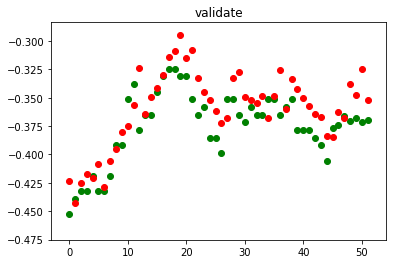

In [11]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

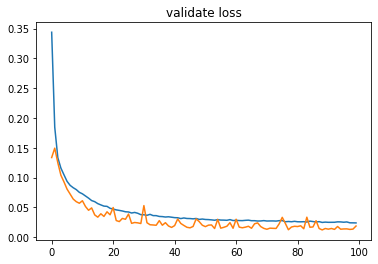

In [12]:



plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

In [13]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,226.999996,231.322992,-4.322996
1,229.000004,228.447827,0.552177
2,230.000007,231.044070,-1.044063
3,230.000007,232.302804,-2.302796
4,231.999997,231.747826,0.252171
5,230.000007,233.543215,-3.543208
6,230.000007,230.543534,-0.543527
7,231.999997,233.905871,-1.905873
8,235.999995,235.543328,0.456666
9,235.999995,237.664318,-1.664324


In [3]:
compara2['real'].plot()
compara2['prediccion'].plot()

In [23]:
ultimosDias = df[3868:3882]
ultimosDias

,cierre,weekday,month,scaled
fecha,,,,
2019-09-19,242.0,3,9,-0.351351
2019-09-20,238.0,4,9,-0.378378
2019-09-23,238.0,0,9,-0.378378
2019-09-24,238.0,1,9,-0.378378
2019-09-25,237.0,2,9,-0.385135
2019-09-26,236.0,3,9,-0.391892
2019-09-27,234.0,4,9,-0.405405
2019-09-30,238.2,0,9,-0.377027
2019-01-10,238.7,3,1,-0.373649


In [24]:
scaledMerge=ultimosDias.drop('cierre',axis=1)
print(scaledMerge.values)

# frame as supervised learning
reframed = series_to_supervised(scaledMerge, PASOS, 1)
newReframed=reframed.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
newReframed.head(7)

[[ 3.          9.         -0.35135126]
 [ 4.          9.         -0.37837827]
 [ 0.          9.         -0.37837827]
 [ 1.          9.         -0.37837827]
 [ 2.          9.         -0.38513505]
 [ 3.          9.         -0.39189184]
 [ 4.          9.         -0.40540528]
 [ 0.          9.         -0.37702692]
 [ 3.          1.         -0.37364852]
 [ 6.          2.         -0.36621606]
 [ 6.          3.         -0.37027025]
 [ 2.          4.         -0.3682431 ]
 [ 0.          6.         -0.37162149]
 [ 2.          7.         -0.36959445]]


,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1)
fecha,,,,,,,,,,,,,,,,,,,,,
2019-09-30,3.0,9.0,-0.351351,4.0,9.0,-0.378378,0.0,9.0,-0.378378,1.0,...,-0.378378,2.0,9.0,-0.385135,3.0,9.0,-0.391892,4.0,9.0,-0.405405
2019-01-10,4.0,9.0,-0.378378,0.0,9.0,-0.378378,1.0,9.0,-0.378378,2.0,...,-0.385135,3.0,9.0,-0.391892,4.0,9.0,-0.405405,0.0,9.0,-0.377027
2019-02-10,0.0,9.0,-0.378378,1.0,9.0,-0.378378,2.0,9.0,-0.385135,3.0,...,-0.391892,4.0,9.0,-0.405405,0.0,9.0,-0.377027,3.0,1.0,-0.373649
2019-03-10,1.0,9.0,-0.378378,2.0,9.0,-0.385135,3.0,9.0,-0.391892,4.0,...,-0.405405,0.0,9.0,-0.377027,3.0,1.0,-0.373649,6.0,2.0,-0.366216
2019-04-10,2.0,9.0,-0.385135,3.0,9.0,-0.391892,4.0,9.0,-0.405405,0.0,...,-0.377027,3.0,1.0,-0.373649,6.0,2.0,-0.366216,6.0,3.0,-0.370270
2019-06-10,3.0,9.0,-0.391892,4.0,9.0,-0.405405,0.0,9.0,-0.377027,3.0,...,-0.373649,6.0,2.0,-0.366216,6.0,3.0,-0.370270,2.0,4.0,-0.368243
2019-07-10,4.0,9.0,-0.405405,0.0,9.0,-0.377027,3.0,1.0,-0.373649,6.0,...,-0.366216,6.0,3.0,-0.370270,2.0,4.0,-0.368243,0.0,6.0,-0.371621


In [25]:
values = newReframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
print(x_test)
ultDiaSemana = newReframed.index[len(newReframed.index)-1].weekday()


(1, 1, 21)
[[[ 4.          9.         -0.40540528  0.          9.
   -0.37702692  3.          1.         -0.37364852  6.
    2.         -0.36621606  6.          3.         -0.37027025
    2.          4.         -0.3682431   0.          6.
   -0.37162149]]]


In [2]:
def agregarNuevoValor(x_test,nuevoValor,ultDiaSemana):
    for i in range(x_test.shape[2]-3):
        x_test[0][0][i] = x_test[0][0][i+3]
    ultDiaSemana=ultDiaSemana+1
    if ultDiaSemana>6:
        ultDiaSemana=0
    x_test[0][0][x_test.shape[2]-3]=ultDiaSemana
    x_test[0][0][x_test.shape[2]-2]=12
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test,ultDiaSemana

In [27]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print('pred',i,x_test)
    x_test,ultDiaSemana=agregarNuevoValor(x_test,parcial[0],ultDiaSemana)

pred 0 [[[ 4.          9.         -0.40540528  0.          9.
   -0.37702692  3.          1.         -0.37364852  6.
    2.         -0.36621606  6.          3.         -0.37027025
    2.          4.         -0.3682431   0.          6.
   -0.37162149]]]
pred 1 [[[ 0.          9.         -0.37702692  3.          1.
   -0.37364852  6.          2.         -0.36621606  6.
    3.         -0.37027025  2.          4.         -0.3682431
    0.          6.         -0.37162149  3.         12.
   -0.35183796]]]
pred 2 [[[ 3.          1.         -0.37364852  6.          2.
   -0.36621606  6.          3.         -0.37027025  2.
    4.         -0.3682431   0.          6.         -0.37162149
    3.         12.         -0.35183796  4.         12.
   -0.34003392]]]
pred 3 [[[ 6.          2.         -0.36621606  6.          3.
   -0.37027025  2.          4.         -0.3682431   0.
    6.         -0.37162149  3.         12.         -0.35183796
    4.         12.         -0.34003392  5.         12.
   -0.3

In [28]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.35183796], dtype=float32), array([-0.34003392], dtype=float32), array([-0.34535637], dtype=float32), array([-0.3437347], dtype=float32), array([-0.33009717], dtype=float32), array([-0.3087464], dtype=float32), array([-0.30067885], dtype=float32)]


array([[241.92796801],
       [243.67496651],
       [242.88724299],
       [243.12724919],
       [245.14560547],
       [248.30551953],
       [249.49951664]])

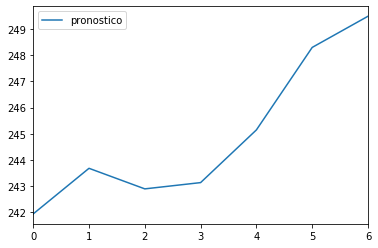

In [29]:
prediccion2SemanaOctubre = pd.DataFrame(inverted)
prediccion2SemanaOctubre.columns = ['pronostico']
prediccion2SemanaOctubre.plot()
prediccion2SemanaOctubre.to_csv('pronostico_multivariate2.csv')


In [30]:
# Una vez finalizado el proceso de predicción, podemos observar los siguientes
# dias hábiles luego del 08/10 que predijo nuestro código.

"""
Utilizamos solo los primeros 3 dias de este dataset ya que fueron los
solicitados en la competencia, para completar así nuestra predicción del
precio de la soja, desde el 30/09 al 11/10.

"""



prediccion2SemanaOctubre

,pronostico
0,241.927968
1,243.674967
2,242.887243
3,243.127249
4,245.145605
5,248.305520
6,249.499517
